In [1]:
# pip install tscluster

In [2]:
# pip install statsmodels

# Imports

In [3]:
from __future__ import annotations

import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mat
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler
from tscluster.tsplot import tsplot as tsp
from tscluster.preprocessing.utils import ntf_to_tnf

import sys
import os

sys.path.append(os.path.abspath('../'))

from codes.model.gct_model import GrangeCausalTree

# Data Prep

In [4]:
chicago_zipcodes = np.load("../Chicago Census/Chicago_zip_codes.npy")
print(len(chicago_zipcodes))
chicago_zipcodes[:5]

67


array([60007, 60018, 60068, 60106, 60131])

Scaling per entity

In [5]:
def scale_per_entity(X):
    ar = []
    for i in range(X.shape[1]):
        sc = StandardScaler()
        ar.append(sc.fit_transform(X[:, i, :]))

    return ntf_to_tnf(np.array(ar))

In [6]:
bp_df_2011 = pd.read_csv("Chicago_BP_API_Datasets_Art/2011.csv", compression='gzip')
print(bp_df_2011.shape)
bp_df_2011.head()

(134790, 3)


,ESTAB,NAICS2007,zipcode
0,61,52,19312
1,45,52,19348
2,142,52,20006
3,5,52,19344
4,6,52,19343


In [7]:
bp_df_2011.dtypes

ESTAB        int64
NAICS2007    int64
zipcode      int64
dtype: object

In [8]:
with open(r"NAICS2012.json", "r") as f:
    NAICS_dict = json.load(f)

In [9]:
chosen_NAICS_2011 = ['52', '54', '55', '62', '72', '71']
chosen_NAICS = ['52', '54', '55', '62', '72', '71']

for i in chosen_NAICS:
    print(f"{i} -> {NAICS_dict[str(i)]}")

52 -> Finance and insurance
54 -> Professional, scientific, and technical services
55 -> Management of companies and enterprises
62 -> Health care and social assistance
72 -> Accommodation and food services
71 -> Arts, entertainment, and recreation


In [10]:
bp_df_lst = []

# chicago_zipcodes_ = list(map(str, chicago_zipcodes))

for year in range(2000, 2020):

    df = pd.read_csv(f"Chicago_BP_API_Datasets_Art/{year}.csv", compression='gzip')

    if year >= 1998 and year <= 2002:
        naics = "NAICS1997"
        
    elif year >= 2003 and year <= 2007:
        naics = "NAICS2002"

    elif year >= 2008 and year <= 2011:
        naics = "NAICS2007"
        
    elif year >= 2012 and year <= 2016:
        naics = "NAICS2012" 
        
    elif year >= 2017 and year <= 2022:
        naics = "NAICS2017"

    if year <= 2011:
        zipcode = 'zipcode'
        # chosen_NAICS = chosen_NAICS_2011
    else:
        zipcode = 'zip code'
        # chosen_NAICS = chosen_NAICS_after_2011

    df = df.rename(columns={naics: 'NAICS', zipcode: 'zip_code'})

    df['ESTAB'] = df['ESTAB'].astype(int)
    df['zip_code'] = df['zip_code'].astype(int)
    df['NAICS'] = df['NAICS'].astype(str)

    df['NAICS'] = df['NAICS'].apply(lambda x: '31-33' if x == '31' else x)

    df = df[(df['zip_code'].isin(chicago_zipcodes)) & (df['NAICS'].isin(chosen_NAICS))]

    df = df.pivot(index='zip_code', columns='NAICS', values='ESTAB')

    bp_df = pd.DataFrame({'zip_code': chicago_zipcodes}).merge(df, how='left', on='zip_code')

    bp_df_lst.append(bp_df)

    print(f"Done with year {year}")

print(bp_df_lst[0].shape)

bp_df_lst[-1].head()

Done with year 2000


Done with year 2001
Done with year 2002
Done with year 2003
Done with year 2004
Done with year 2005
Done with year 2006
Done with year 2007
Done with year 2008
Done with year 2009
Done with year 2010
Done with year 2011
Done with year 2012
Done with year 2013
Done with year 2014
Done with year 2015
Done with year 2016
Done with year 2017
Done with year 2018
Done with year 2019
(67, 7)


,zip_code,52,54,55,62,71,72
0,60007,80.0,159.0,18.0,148.0,16.0,123.0
1,60018,117.0,189.0,49.0,84.0,17.0,171.0
2,60068,99.0,237.0,3.0,271.0,21.0,77.0
3,60106,23.0,55.0,4.0,29.0,9.0,42.0
4,60131,22.0,26.0,4.0,38.0,5.0,50.0


In [11]:
bp_df_lst[0].head()

,zip_code,52,54,55,62,71,72
0,60007,74.0,158.0,34.0,111.0,9.0,110.0
1,60018,148.0,240.0,45.0,65.0,5.0,105.0
2,60068,134.0,251.0,10.0,196.0,12.0,64.0
3,60106,34.0,81.0,9.0,22.0,6.0,45.0
4,60131,23.0,41.0,8.0,34.0,3.0,44.0


In [12]:
bp_df_lst[-1].isnull().sum()

zip_code     0
52           1
54           0
55          30
62           0
71           5
72           0
dtype: int64

In [13]:
bp_df_lst[-1].describe()

,zip_code,52,54,55,62,71,72
count,67.000000,66.000000,67.000000,37.000000,67.000000,62.000000,67.000000
mean,60590.104478,74.681818,172.895522,16.837838,117.089552,20.290323,115.179104
std,165.458237,112.552369,221.446015,21.251815,76.731277,18.748016,81.553649
min,60007.000000,3.000000,5.000000,3.000000,10.000000,3.000000,18.000000
25%,60611.500000,23.750000,31.000000,4.000000,60.000000,6.000000,54.000000
50%,60629.000000,52.500000,88.000000,6.000000,97.000000,12.000000,90.000000
75%,60646.500000,81.500000,246.500000,20.000000,146.500000,27.000000,164.500000
max,60827.000000,864.000000,1048.000000,92.000000,404.000000,73.000000,331.000000


In [14]:
bp_df_lst[-1][bp_df_lst[-1]['55'].isnull()]

,zip_code,52,54,55,62,71,72
20,60615,26.0,68.0,NaN,92.0,11.0,78.0
22,60617,35.0,40.0,NaN,140.0,6.0,90.0
23,60618,100.0,265.0,NaN,198.0,57.0,216.0
24,60619,37.0,24.0,NaN,129.0,NaN,69.0
25,60620,32.0,17.0,NaN,76.0,6.0,68.0
26,60621,3.0,6.0,NaN,57.0,NaN,21.0
29,60624,7.0,11.0,NaN,52.0,NaN,23.0
30,60625,56.0,162.0,NaN,188.0,40.0,159.0
31,60626,32.0,57.0,NaN,81.0,18.0,83.0
32,60628,23.0,18.0,NaN,90.0,7.0,64.0


In [15]:
bp_df_lst[-1][bp_df_lst[-1]['71'].isnull()]

,zip_code,52,54,55,62,71,72
24,60619,37.0,24.0,NaN,129.0,NaN,69.0
26,60621,3.0,6.0,NaN,57.0,NaN,21.0
29,60624,7.0,11.0,NaN,52.0,NaN,23.0
39,60636,16.0,7.0,NaN,30.0,NaN,34.0
53,60652,15.0,22.0,NaN,54.0,NaN,52.0


In [16]:
bp_df_lst[-2][bp_df_lst[-2]['71'].isnull()]

,zip_code,52,54,55,62,71,72
24,60619,34.0,24.0,NaN,132.0,NaN,65.0
26,60621,3.0,4.0,NaN,61.0,NaN,20.0
29,60624,7.0,11.0,NaN,48.0,NaN,24.0
39,60636,16.0,7.0,NaN,31.0,NaN,29.0
47,60644,6.0,9.0,NaN,57.0,NaN,30.0


In [17]:
bp_df_lst[-3][bp_df_lst[-3]['71'].isnull()]

,zip_code,52,54,55,62,71,72
5,60176,11.0,25.0,4.0,11.0,NaN,48.0
24,60619,37.0,21.0,NaN,132.0,NaN,62.0
26,60621,4.0,5.0,NaN,61.0,NaN,20.0
29,60624,6.0,11.0,NaN,46.0,NaN,26.0
32,60628,22.0,17.0,NaN,93.0,NaN,67.0
39,60636,18.0,8.0,NaN,32.0,NaN,36.0
47,60644,7.0,11.0,NaN,54.0,NaN,33.0
54,60653,16.0,20.0,NaN,54.0,NaN,29.0


In [18]:
bp_df_lst[-4][bp_df_lst[-4]['71'].isnull()]

,zip_code,52,54,55,62,71,72
39,60636,19.0,8.0,2.0,33.0,NaN,36.0


In [19]:
for i in range(len(bp_df_lst)):
    print(f"year {np.arange(2000, 2020)[i]}, {bp_df_lst[i].shape[0]} zipcodes, {bp_df_lst[i][bp_df_lst[i]['71'].isnull()].shape[0]} has nan")
    

year 2000, 67 zipcodes, 2 has nan
year 2001, 67 zipcodes, 2 has nan
year 2002, 67 zipcodes, 2 has nan
year 2003, 67 zipcodes, 3 has nan
year 2004, 67 zipcodes, 3 has nan
year 2005, 67 zipcodes, 3 has nan
year 2006, 67 zipcodes, 2 has nan
year 2007, 67 zipcodes, 1 has nan
year 2008, 67 zipcodes, 1 has nan
year 2009, 67 zipcodes, 1 has nan
year 2010, 67 zipcodes, 1 has nan
year 2011, 67 zipcodes, 0 has nan
year 2012, 67 zipcodes, 0 has nan
year 2013, 67 zipcodes, 0 has nan
year 2014, 67 zipcodes, 0 has nan
year 2015, 67 zipcodes, 0 has nan
year 2016, 67 zipcodes, 1 has nan
year 2017, 67 zipcodes, 8 has nan
year 2018, 67 zipcodes, 5 has nan
year 2019, 67 zipcodes, 5 has nan


Drop NAICS code 55

In [20]:
chosen_NAICS

['52', '54', '55', '62', '72', '71']

In [21]:
chosen_NAICS = ['52', '54', '62', '72', '71']

Fill Nans with Zeros

In [22]:
for i in range(len(bp_df_lst)):
    bp_df_lst[i] = bp_df_lst[i].fillna(0)

In [23]:
bp_arr = np.array([bp_df[chosen_NAICS].values for bp_df in bp_df_lst])
print(bp_arr.shape)
bp_arr[:3, :3, :]

(20, 67, 5)


array([[[ 74., 158., 111., 110.,   9.],
        [148., 240.,  65., 105.,   5.],
        [134., 251., 196.,  64.,  12.]],

       [[ 67., 179., 114., 111.,   9.],
        [146., 234.,  61., 114.,   4.],
        [133., 262., 210.,  69.,  12.]],

       [[ 68., 188., 125., 107.,  14.],
        [143., 226.,  53., 111.,   4.],
        [127., 270., 206.,  65.,  11.]]])

In [24]:
np.isnan(bp_arr).sum()

0

In [25]:
NAICS_names = [NAICS_dict[k] for k in chosen_NAICS]
NAICS_names

['Finance and insurance',
 'Professional, scientific, and technical services',
 'Health care and social assistance',
 'Accommodation and food services',
 'Arts, entertainment, and recreation']

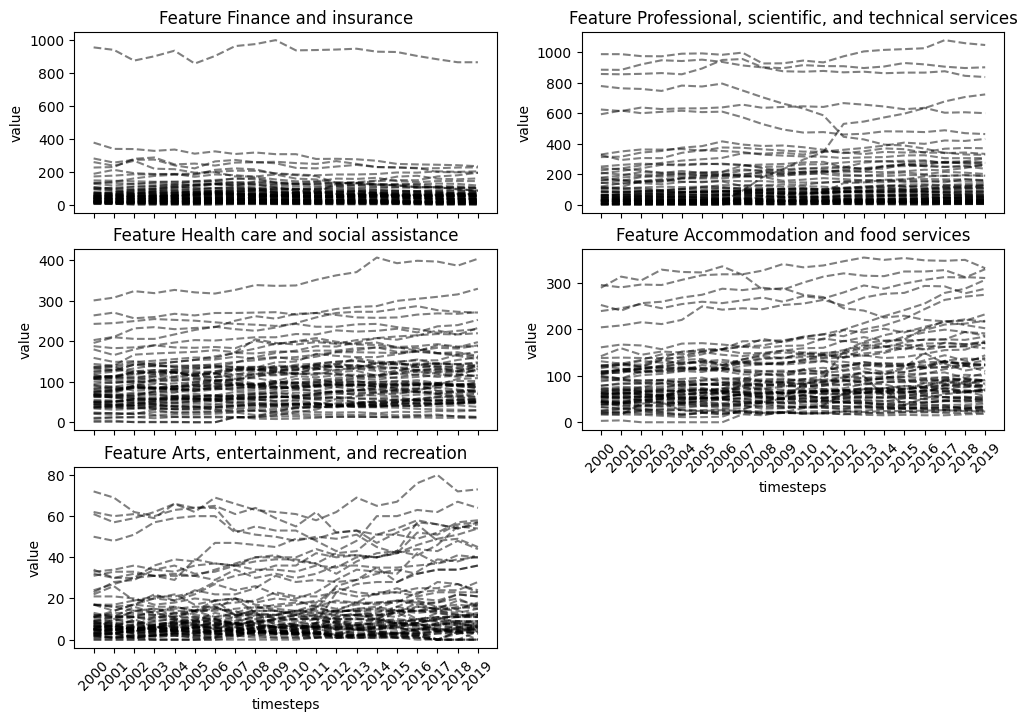

In [26]:
label_dict = {
    'T': np.arange(2000, 2020),
    'F': NAICS_names
}

fig, ax = tsp.plot(X=bp_arr, label_dict=label_dict, figsize=(12, 8), shape_of_subplot=(3, 2))
plt.show()

Scale

Scaling per entity

In [27]:
bp_arr_scaled = scale_per_entity(bp_arr)
print(bp_arr_scaled.shape)
bp_arr_scaled[:3, :3, :]

(20, 67, 5)


array([[[-0.71250559, -1.28074036, -1.68381827, -0.83153236,
         -2.09255535],
        [ 1.08735493,  2.36130132, -0.50663335, -1.57337519,
         -0.81115571],
        [ 1.04569161, -0.08178019, -1.7064077 , -1.20482899,
         -0.79656623]],

       [[-1.49794483,  0.49454331, -1.43800538, -0.70458086,
         -2.09255535],
        [ 0.92384291,  1.98993021, -0.83349357, -1.18595038,
         -1.02184551],
        [ 0.97256632,  0.77496466, -1.21736558, -0.05737281,
         -0.79656623]],

       [[-1.38573923,  1.25537916, -0.53669147, -1.21238688,
         -0.55391171],
        [ 0.67857488,  1.49476873, -1.48721402, -1.31509198,
         -1.02184551],
        [ 0.5338146 ,  1.39805182, -1.3570919 , -0.97533776,
         -1.11519273]]])

# Clustering

In [28]:
ts_arr = np.copy(bp_arr_scaled)
ts_arr.shape

(20, 67, 5)

In [29]:
y_var = ['ArtsEntertainment&Recreation']
x_vars = [
    'Finance&Insurance',
    'ProfessionalScientific&Technical_services',
    'Health_care&Social_assistance',
    'Accommodation&Food_services'
    ]

# 52 -> Finance and insurance
# 54 -> Professional, scientific, and technical services
# 62 -> Health care and social assistance
# 72 -> Accommodation and food services
# 71 -> Arts, entertainment, and recreation

vars = y_var + x_vars


# Map

In [30]:
gdf = gpd.read_file(r"..\US_shape_file.zip")
print(gdf.shape)
gdf.head()

(33144, 6)


,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,35586,8600000US35586,35586,472581657,892816,"MULTIPOLYGON (((-88.0016 33.811, -88.00258 33...."
1,72454,8600000US72454,72454,263532032,775633,"POLYGON ((-90.41711 36.36553, -90.41686 36.390..."
2,71653,8600000US71653,71653,817752215,89308151,"POLYGON ((-91.45936 33.30273, -91.45758 33.381..."
3,19963,8600000US19963,19963,276290156,21123546,"POLYGON ((-75.50557 38.92751, -75.50313 38.927..."
4,81303,8600000US81303,81303,557450510,6445737,"POLYGON ((-108.04031 37.09764, -108.03896 37.1..."


In [31]:
gdf = gdf[gdf['ZCTA5CE10'].astype(int).isin(chicago_zipcodes)][['ZCTA5CE10', 'geometry']].rename(columns={'ZCTA5CE10': 'zip_code'})
gdf['zip_code'] = gdf['zip_code'].astype(int)
print(gdf.shape)
gdf.head()

(67, 2)


,zip_code,geometry
418,60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."
422,60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845..."
424,60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964..."
1338,60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949..."
1562,60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882..."


aligning the ordering of the zipcodes

In [32]:
gdf = gdf.set_index('zip_code')#.loc[zip_codes[chicago_mask], :].loc[chicago_zipcodes[chicago_mask2]]
print(gdf.shape)
gdf.head()

(67, 1)


,geometry
zip_code,
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."
60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845..."
60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964..."
60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949..."
60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882..."


In [33]:
gct = GrangeCausalTree(k=3, maxlag=1, fit_intercept=True)
gct.fit(ts_arr)

labels = gct.labels_
important_feature_set = gct.important_feature_set_

In [34]:

years = list(map(str, range(2000, 2020))) # change in current year wrt prev year

gdf['label'] = list(map(lambda x: f" {tuple([x_vars[i] for i in important_feature_set[x]])}", labels))

for t in range(len(years)):
    gdf[[v + "_" + years[t] for v in x_vars + y_var]] = ts_arr[t, :, :]

gdf.head()

,geometry,label,Finance&Insurance_2000,ProfessionalScientific&Technical_services_2000,Health_care&Social_assistance_2000,Accommodation&Food_services_2000,ArtsEntertainment&Recreation_2000,Finance&Insurance_2001,ProfessionalScientific&Technical_services_2001,Health_care&Social_assistance_2001,...,Finance&Insurance_2018,ProfessionalScientific&Technical_services_2018,Health_care&Social_assistance_2018,Accommodation&Food_services_2018,ArtsEntertainment&Recreation_2018,Finance&Insurance_2019,ProfessionalScientific&Technical_services_2019,Health_care&Social_assistance_2019,Accommodation&Food_services_2019,ArtsEntertainment&Recreation_2019
zip_code,,,,,,,,,,,,,,,,,,,,,
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575...","('Accommodation&Food_services',)",-0.712506,-1.280740,-1.683818,-0.831532,-2.092555,-1.497945,0.494543,-1.438005,...,-1.049122,-0.519905,0.938186,1.199692,1.292461,-0.039272,-1.196203,1.347874,0.818837,0.061546
60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845...","('Health_care&Social_assistance',)",1.087355,2.361301,-0.506633,-1.573375,-0.811156,0.923843,1.989930,-0.833494,...,-0.629521,-0.547772,1.454528,1.138598,2.138501,-1.447081,-0.795353,1.045953,1.267740,1.717122
60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964...","('Accommodation&Food_services',)",1.045692,-0.081780,-1.706408,-1.204829,-0.796566,0.972566,0.774965,-1.217366,...,-1.294318,-0.081780,0.983324,1.778557,2.389699,-1.513693,-1.172183,0.913461,1.778557,2.071072
60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949...","('ProfessionalScientific&Technical_services',)",1.058281,0.585243,-1.360749,-0.186352,-0.912871,1.243944,0.680405,-0.921798,...,-0.984016,-1.508310,0.834007,0.346083,1.825742,-0.984016,-1.888956,1.711910,-0.985005,1.825742
60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882...","('Accommodation&Food_services',)",0.681994,2.794859,-1.577547,-0.296908,0.062137,0.340997,2.239589,-2.514704,...,0.340997,0.018509,0.921538,0.816497,1.304877,0.340997,0.018509,-0.328005,1.929901,2.547616


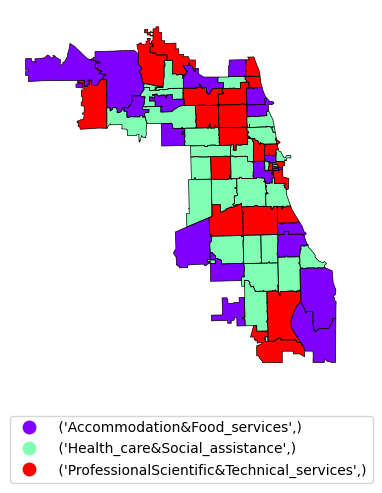

In [35]:
cmap = mat.colormaps.get_cmap('rainbow')

k = len(np.unique(labels))

norm = plt.Normalize(vmin=0, vmax=k-1)

gdf.plot(column='label', legend=True, categorical=True, cmap=cmap, legend_kwds={'loc': (0, -0.28)})
gdf.boundary.plot(color='k', linewidth=0.5, ax=plt.gca())
plt.axis('off') 
# plt.savefig('Chicago_BP_GCT_choropleth_k5.svg', bbox_inches='tight')
plt.show()

In [36]:
important_feature_set

{0: (2,), 1: (3,), 2: (1,)}

## Clusters

In [37]:
important_feature_set

{0: (2,), 1: (3,), 2: (1,)}

In [38]:
def get_most_gc_entity(custer_idx):
    arr = ts_arr[:, labels==custer_idx, :].copy()

    lrs = np.array([gct.get_likelihoods(arr[:, [i], :], {0: important_feature_set[custer_idx]}, 
                                    which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])

    max_lr_idx = np.argmax(lrs.flatten())
    zc = chicago_zipcodes[labels == custer_idx][max_lr_idx]

    print(f"coefficients are: {gct.get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[custer_idx]}, which='unrestricted', return_thetas=True)[1]}")

    return zc
# first feature is the feature of interest, target and intercept are last

In [39]:
def plot_most_gc_entity(cluster_idx, zc):
    var_idx = important_feature_set[cluster_idx]

    if len(var_idx) > 1:
        fig = plt.figure(figsize=(12, 4))
        
    x_year = np.arange(2000, 2019).astype(int)

    for f in range(len(var_idx)):
        plt.subplot(1, len(var_idx), f+1)
        plt.plot(x_year, ts_arr[:-1, chicago_zipcodes == zc, var_idx[f]].flatten(), label=f"current year's {x_vars[var_idx[f]]}", marker='*')
        plt.plot(x_year, ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label=f"next year's {y_var[0]}", marker='*')
        plt.ylabel("zscore value")
        plt.xlabel('Year')
        plt.xticks(x_year[::2], x_year[::2])

        plt.legend(loc=(0, -0.3))

    plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
    # plt.savefig(f'BP_cluster_{cluster_idx}.svg', bbox_inches='tight')
    plt.show()

    return var_idx

In [40]:
def coint_test(var_idx, zc):
    zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

    if len(var_idx) == 1:
        coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

        print(f"Test Statistic: {coint_t}")
        print(f"P-value: {p_value}")
        print(f"Critical Values: {critical_values}")

    else:
            
        result = coint_johansen(zip_code_ts_arr[:, 0, list(var_idx)+[-1]], det_order=0, k_ar_diff=0)
            
        # Check the trace statistic against critical values
        for i, trace_stat in enumerate(result.lr1):
            critical_value_90 = result.cvt[i, 0]  # 90% critical value
            
            # If trace statistic is greater than the 90% critical value, print the critical values
            if trace_stat > critical_value_90:
                print(f"Rank {i}: Trace statistic ({trace_stat}) > 90% critical value ({critical_value_90})")
                print("Cointegrating relationship exists!")
                print(f"Critical values (90%, 95%, 99%): {result.cvt[i]}")

                break

        else:
            print("Not cointegrating")

In [41]:
def scatter_plot_of_most_gc_entity(var_idx, zc):
    zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

    if len(var_idx) > 1:
        fig = plt.figure(figsize=(12, 4))
    for f in range(len(var_idx)):
        plt.subplot(1, len(var_idx), f+1)
        plt.scatter(zip_code_ts_arr[:-1, 0, var_idx[f]], zip_code_ts_arr[1:, 0, -1])
        plt.xlabel(f"current year's {x_vars[var_idx[f]]} (zscore)")

        if f == 0:
            plt.ylabel(f"next year's {y_var[0]} (zscore)")

    plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
    # plt.savefig(f'BP_zipcode_{zc}.svg', bbox_inches='tight')
    plt.show()

# Cluster 0

In [42]:
j = 0
zc = get_most_gc_entity(j)
zc

coefficients are: [ 1.49414961 -0.46374729  0.15694765]


60642

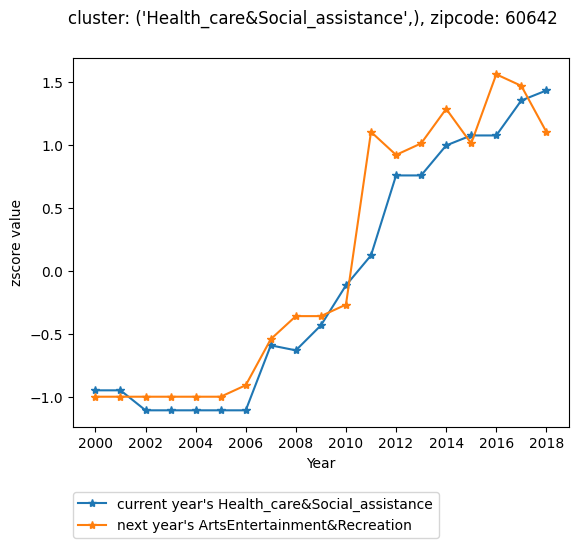

In [43]:
var_idx = plot_most_gc_entity(j, zc)

In [44]:
coint_test(var_idx, zc)

Test Statistic: -3.5854879308201095
P-value: 0.025532799625089093
Critical Values: [-4.60835728 -3.69663864 -3.28846728]


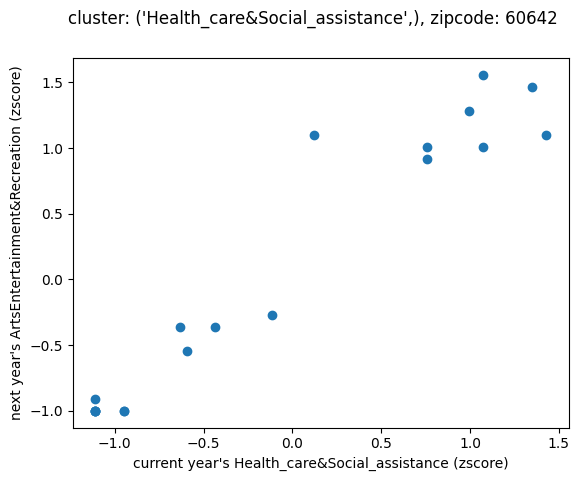

In [45]:
scatter_plot_of_most_gc_entity(var_idx, zc)

# Cluster 1

In [46]:
j = 1
zc = get_most_gc_entity(j)
zc

coefficients are: [ 1.10119275 -0.11516308  0.17082999]


60607

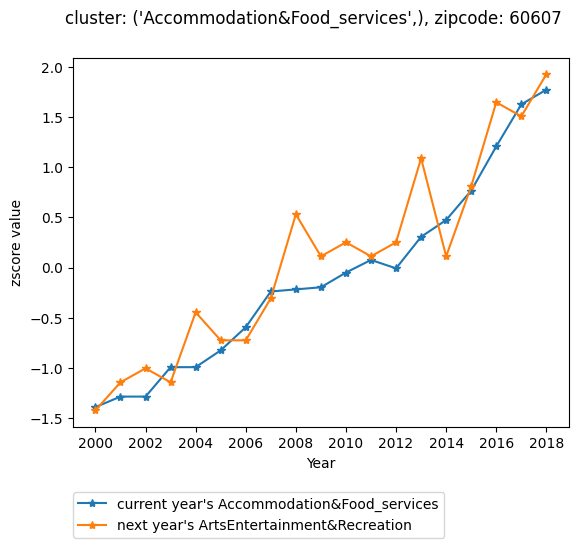

In [47]:
var_idx = plot_most_gc_entity(j, zc)

In [48]:
coint_test(var_idx, zc)

Test Statistic: -4.9341465555867
P-value: 0.00021718077607992404
Critical Values: [-4.60835728 -3.69663864 -3.28846728]


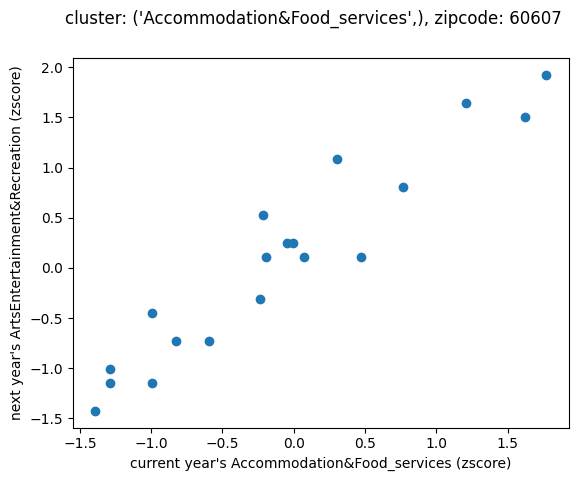

In [49]:
scatter_plot_of_most_gc_entity(var_idx, zc)

# Cluster 2

In [50]:
j = 2
zc = get_most_gc_entity(j)
zc

coefficients are: [0.57195267 0.40227163 0.23444466]


60612

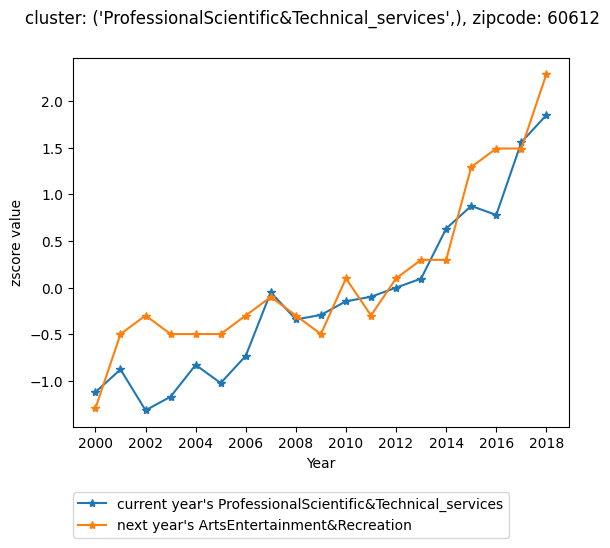

In [51]:
var_idx = plot_most_gc_entity(j, zc)

In [52]:
coint_test(var_idx, zc)

Test Statistic: -2.5417115213073176
P-value: 0.2609892531291402
Critical Values: [-4.60835728 -3.69663864 -3.28846728]


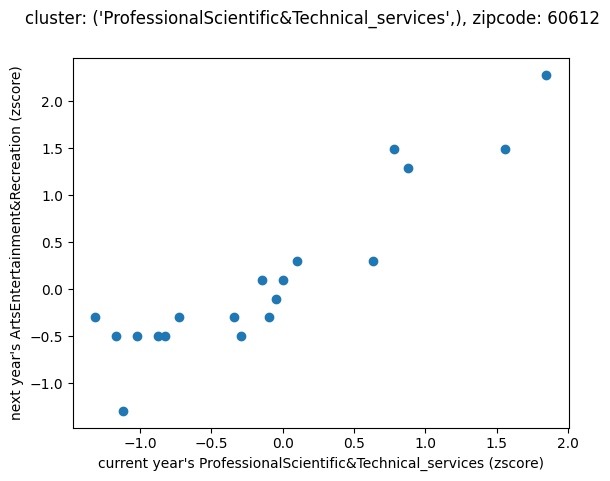

In [53]:
scatter_plot_of_most_gc_entity(var_idx, zc)